In [1]:
# import os
# import gdown
# import zipfile

# # Define the Google Drive file ID and output filename
# file_id = "1uJmDZw649XS-r-dYs9WD-OPwF_TIroVw"
# output_file = "dataset.zip"

# # Download the file using gdown
# gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", output_file, quiet=False)

# # Create a directory for extraction
# extract_dir = "dataset"
# os.makedirs(extract_dir, exist_ok=True)

# # Unzip the file
# try:
#     with zipfile.ZipFile(output_file, 'r') as zip_ref:
#         zip_ref.extractall(extract_dir)
#     print("Extraction successful!")
# except zipfile.BadZipFile:
#     print("Error: The downloaded file is not a valid ZIP file.")

# # List extracted files
# extracted_files = os.listdir(extract_dir)
# print("Extracted files:", extracted_files)


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from einops import rearrange


In [3]:
print(len(os.listdir("dataset/Dataset/HR")))
print(len(os.listdir("dataset/Dataset/LR")))

10000
10000


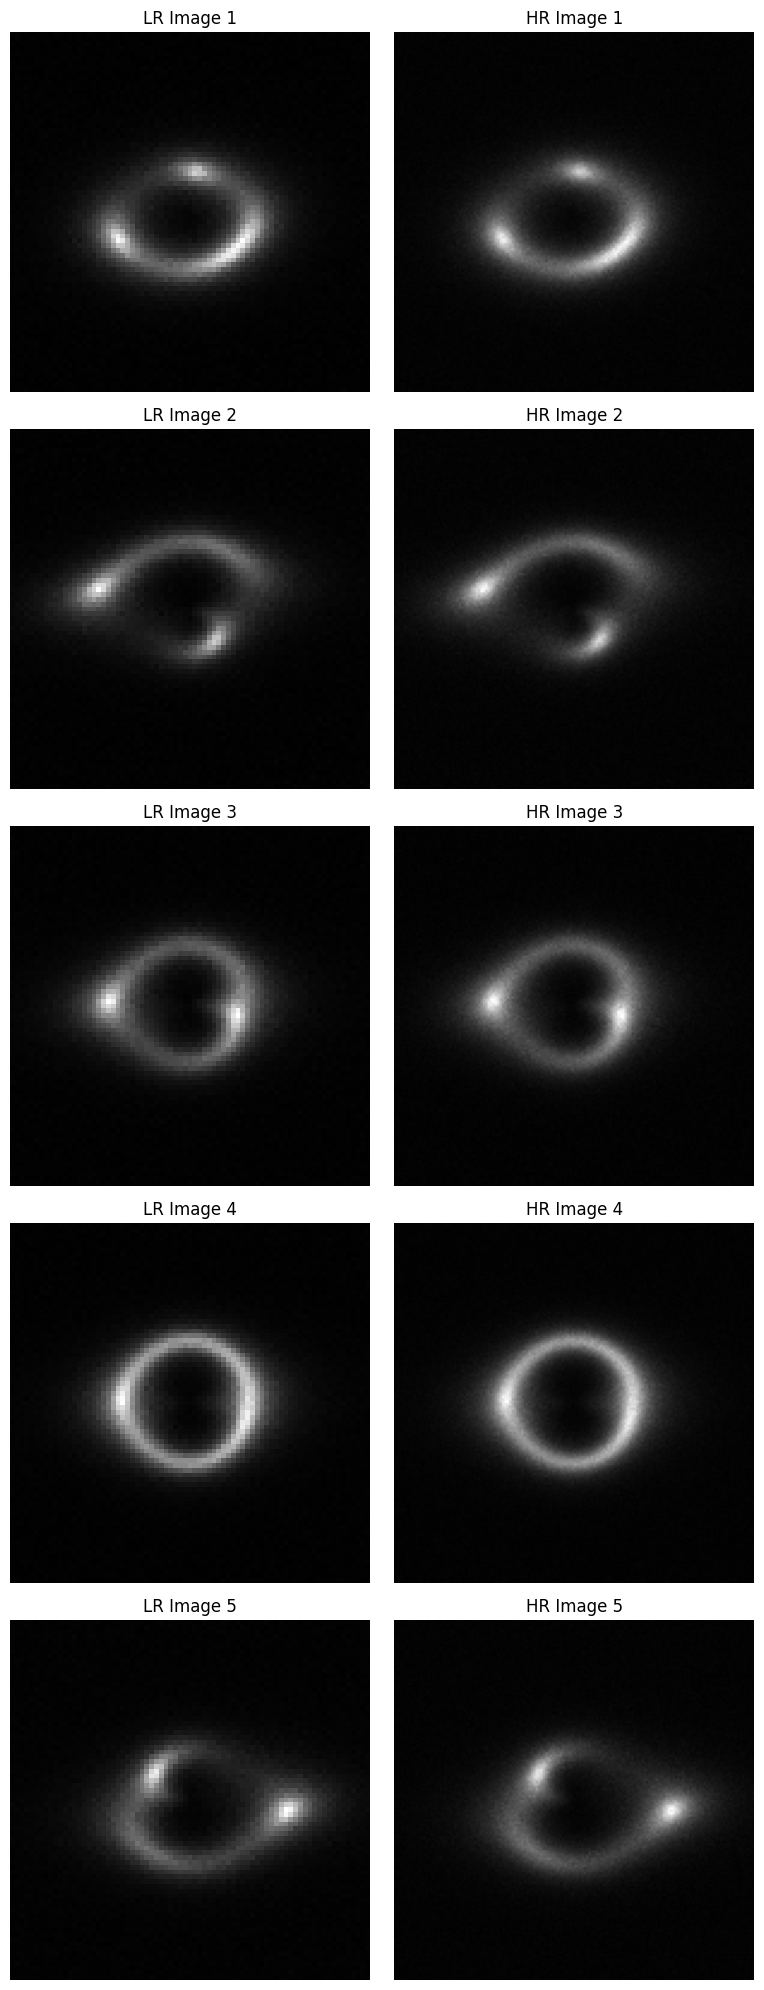

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define dataset paths
dataset_path = "dataset/Dataset"  # Please update the path as per the directory structure you are using! [sorry for having to do this]
hr_path = os.path.join(dataset_path, "HR")
lr_path = os.path.join(dataset_path, "LR")

# Ensure directories exist
if not os.path.exists(hr_path) or not os.path.exists(lr_path):
    raise FileNotFoundError("HR or LR directory not found. Check your dataset path.")

# List .npy files in HR and LR directories
hr_files = sorted([f for f in os.listdir(hr_path) if f.endswith(".npy")])
lr_files = sorted([f for f in os.listdir(lr_path) if f.endswith(".npy")])

# Check if HR and LR datasets are aligned
if len(hr_files) != len(lr_files):
    raise ValueError("Mismatch in number of HR and LR images.")

# Load a few samples for visualization
num_samples = min(5, len(hr_files))  # Adjust number of samples to display

hr_images = [np.load(os.path.join(hr_path, hr_files[i])).squeeze() for i in range(num_samples)]
lr_images = [np.load(os.path.join(lr_path, lr_files[i])).squeeze() for i in range(num_samples)]

# Plot HR and LR images side by side
fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

for i in range(num_samples):
    axes[i, 0].imshow(lr_images[i], cmap="gray")
    axes[i, 0].set_title(f"LR Image {i+1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(hr_images[i], cmap="gray")
    axes[i, 1].set_title(f"HR Image {i+1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:

# Define Masked Autoencoder
class MaskedAutoencoder(nn.Module):
    def __init__(self, img_size=64, hidden_dim=256, mask_ratio=0.75):
        super(MaskedAutoencoder, self).__init__()
        self.mask_ratio = mask_ratio
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        mask = (torch.rand_like(x) > self.mask_ratio).float()
        masked_x = x * mask
        encoded = self.encoder(masked_x)
        reconstructed = self.decoder(encoded)
        return reconstructed, mask

In [7]:
# Load the saved MAE model
mae_finetune = MaskedAutoencoder().to(device)
mae_finetune.load_state_dict(torch.load("../Task VI A/mae_pretrained.pth"))

print("Pretrained MAE model loaded successfully!")


Pretrained MAE model loaded successfully!


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define Super-Resolution Model using MAE encoder
class SuperResolutionMAE(nn.Module):
    def __init__(self, mae_encoder, upscale_factor=2):
        super(SuperResolutionMAE, self).__init__()
        
        # Use the pretrained MAE encoder
        self.encoder = mae_encoder  # Encoder from MAE

        # Decoder: Upsampling network for Super-Resolution
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=upscale_factor, mode="bilinear", align_corners=False)  # Upsampling
        )
    
    def forward(self, x):
        encoded = self.encoder(x)  # Feature extraction using MAE encoder
        upscaled = self.decoder(encoded)  # Super-resolution decoding
        return upscaled

# Initialize the Super-Resolution model with the pretrained MAE encoder
mae_encoder = mae_finetune.encoder  # Extract the encoder from the pretrained MAE
super_res_model = SuperResolutionMAE(mae_encoder).to(device)

# Print model summary
print(super_res_model)


SuperResolutionMAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Upsample(scale_factor=2.0, mode='bilinear')
  )
)


In [9]:
from sklearn.model_selection import train_test_split

# Load dataset file paths
lr_files = sorted([os.path.join(lr_path, f) for f in os.listdir(lr_path) if f.endswith(".npy")])
hr_files = sorted([os.path.join(hr_path, f) for f in os.listdir(hr_path) if f.endswith(".npy")])

# Train-Validation Split (80-20)
train_lr, val_lr, train_hr, val_hr = train_test_split(lr_files, hr_files, test_size=0.1, random_state=42)

# Define Dataset Class
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_files, hr_files):
        self.lr_files = lr_files
        self.hr_files = hr_files

    def __len__(self):
        return len(self.lr_files)

    def __getitem__(self, idx):
        lr_image = np.load(self.lr_files[idx]).squeeze()
        hr_image = np.load(self.hr_files[idx]).squeeze()

        # Convert to PyTorch tensors and normalize
        lr_tensor = torch.tensor(lr_image, dtype=torch.float32).unsqueeze(0)  # Add channel dim (1, H, W)
        hr_tensor = torch.tensor(hr_image, dtype=torch.float32).unsqueeze(0)

        return lr_tensor, hr_tensor

# Create Train and Validation Datasets
train_dataset = SuperResolutionDataset(train_lr, train_hr)
val_dataset = SuperResolutionDataset(val_lr, val_hr)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Training Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")


Training Samples: 9000, Validation Samples: 1000


In [10]:
import torch.optim as optim

# Define loss functions
mse_loss = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(super_res_model.parameters(), lr=1e-4)


In [11]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Define SSIM loss using torchmetrics
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

def ssim_loss(pred, target):
    return 1 - ssim_metric(pred, target)  # Convert SSIM score to loss


In [12]:
import torchmetrics
import math

# PSNR Metric
def psnr(pred, target):
    mse = mse_loss(pred, target)
    return 20 * math.log10(1.0) - 10 * math.log10(mse.item())

In [13]:


# Best Validation Loss Tracker
best_val_loss = float("inf")

num_epochs = 20
for epoch in range(num_epochs):
    super_res_model.train()
    total_train_loss = 0.0
    
    for lr_imgs, hr_imgs in train_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        optimizer.zero_grad()

        sr_imgs = super_res_model(lr_imgs)
        loss = mse_loss(sr_imgs, hr_imgs) + 0.1 * ssim_loss(sr_imgs, hr_imgs)

        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    # Validation Phase
    super_res_model.eval()
    total_val_loss = 0.0
    total_psnr = 0.0

    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            sr_imgs = super_res_model(lr_imgs)
            val_loss = mse_loss(sr_imgs, hr_imgs) + 0.1 * ssim_loss(sr_imgs, hr_imgs)

            total_val_loss += val_loss.item()
            total_psnr += psnr(sr_imgs, hr_imgs)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    avg_psnr = total_psnr / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {avg_train_loss:.6f}")
    print(f"  Val Loss: {avg_val_loss:.6f}, PSNR: {avg_psnr:.2f}")

    # Save Best Model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(super_res_model.state_dict(), "best_super_res_mae.pth")
        print("  ** Model Saved **")


Epoch [1/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
  ** Model Saved **
Epoch [2/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [3/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [4/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [5/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [6/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [7/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [8/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [9/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [10/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [11/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [12/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [13/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 17.59
Epoch [14/20]
  Train Loss: 0.095538
  Val Loss: 0.095765, PSNR: 1

In [14]:
# Save the final model after training
torch.save(super_res_model.state_dict(), "best_super_res_mae.pth")
print("Final trained model")


Final trained model


In [15]:
# Reload the trained model for inference
super_res_model.load_state_dict(torch.load("best_super_res_mae.pth"))
super_res_model.eval()  # Set model to evaluation mode
print("Model loaded successfully for inference!")


Model loaded successfully for inference!


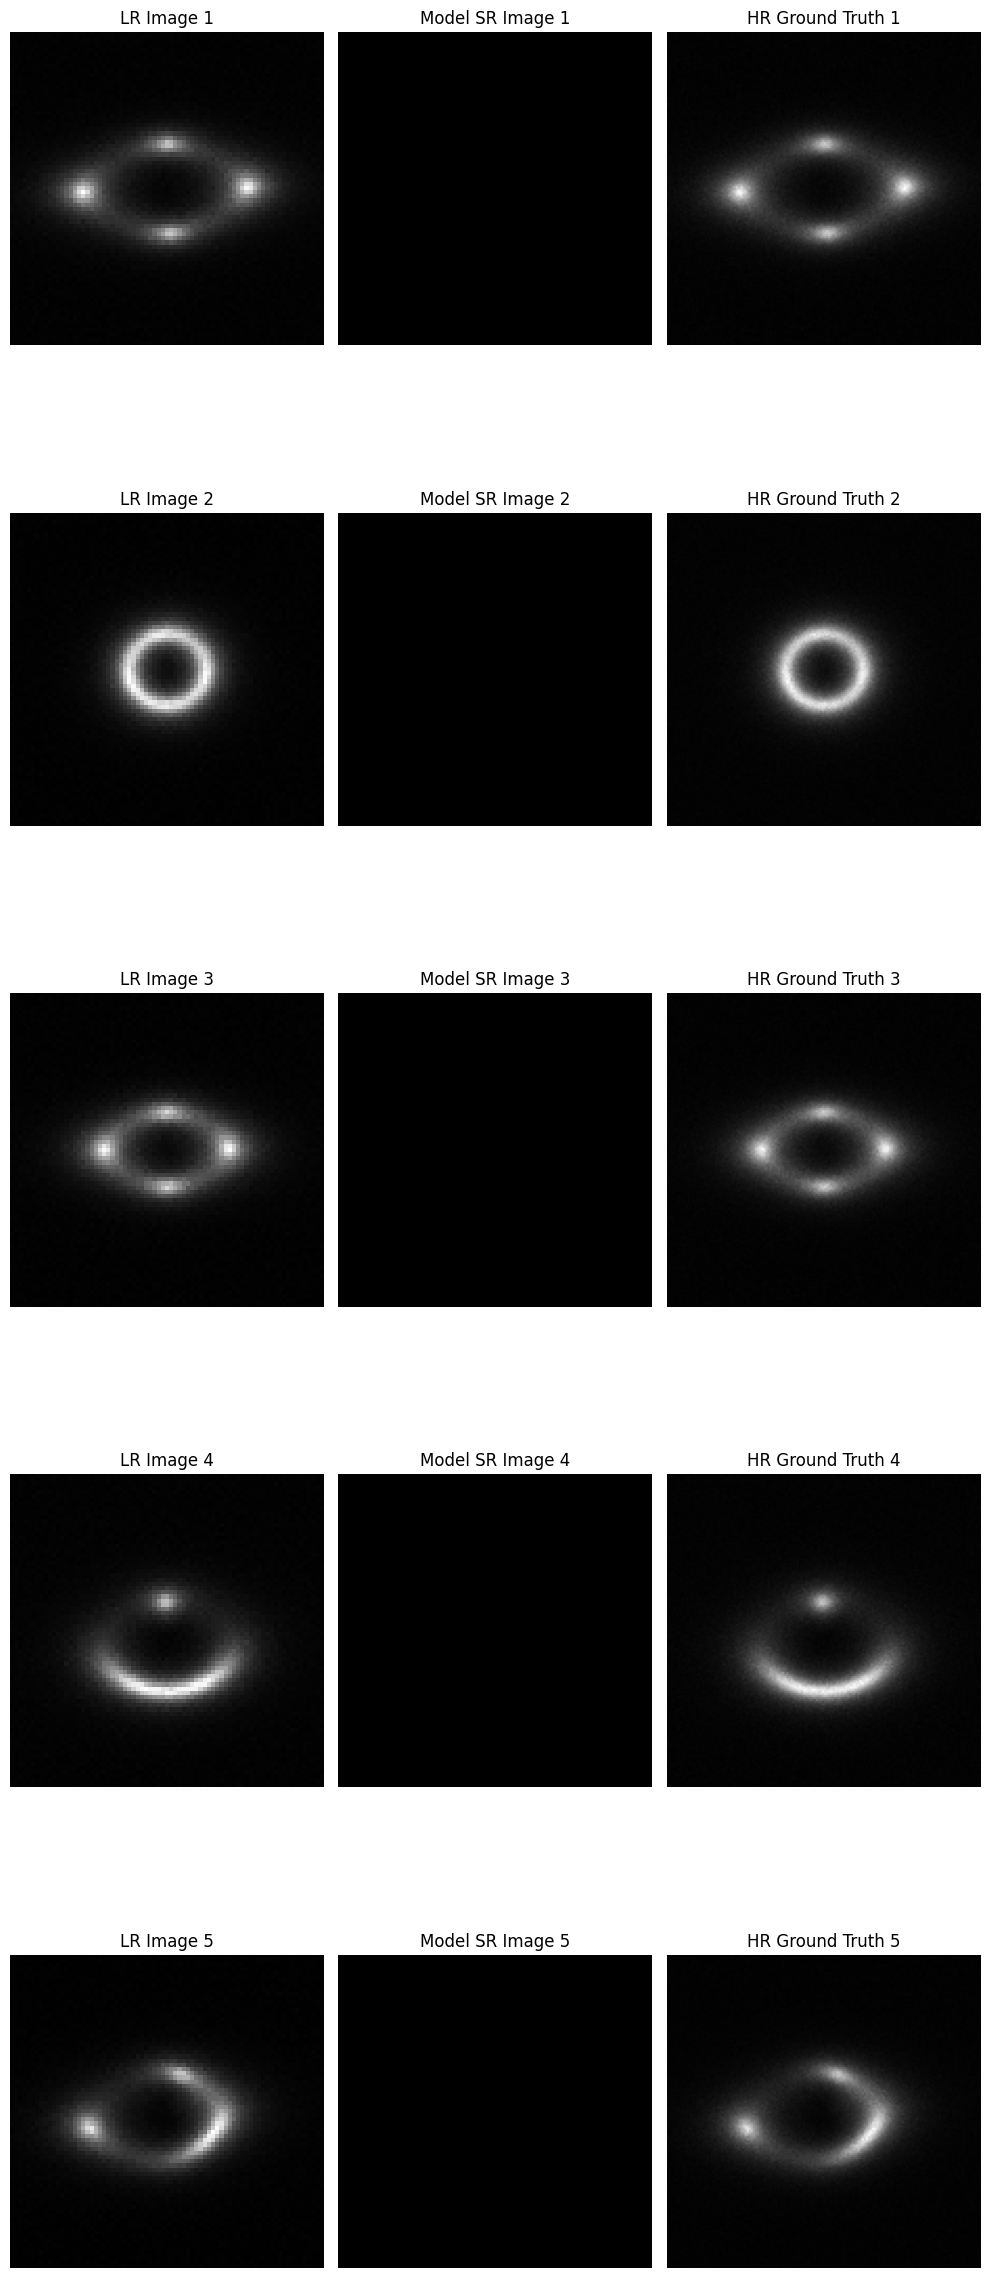

In [18]:
import matplotlib.pyplot as plt

# Select a few samples from the validation set
num_samples = 5  # Number of images to visualize
val_loader_iter = iter(val_loader)  # Create an iterator from val_loader

# Set model to evaluation mode
super_res_model.eval()

# Plot the images
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))

for i in range(num_samples):
    lr_img, hr_img = next(val_loader_iter)
    lr_img, hr_img = lr_img.to(device), hr_img.to(device)

    # Select the first image from the batch
    lr_img = lr_img[0]  # Remove batch dimension
    hr_img = hr_img[0]

    # Generate super-resolution output
    with torch.no_grad():
        sr_img = super_res_model(lr_img.unsqueeze(0))  # Add batch dimension for model input

    # Convert tensors to numpy for plotting
    lr_np = lr_img.squeeze().cpu().numpy()  # Remove (1, H, W) → (H, W)
    sr_np = sr_img.squeeze().cpu().numpy()
    hr_np = hr_img.squeeze().cpu().numpy()

    # Plot images side by side
    axes[i, 0].imshow(lr_np, cmap="gray")
    axes[i, 0].set_title(f"LR Image {i+1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(sr_np, cmap="gray")
    axes[i, 1].set_title(f"Model SR Image {i+1}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(hr_np, cmap="gray")
    axes[i, 2].set_title(f"HR Ground Truth {i+1}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()
